
# Diseño de software para cómputo científico

----

## Unidad 5: Compiladores Just in Time (JIT)


## Mini repaso de decoradores

Vimos que esto:

```python
def func():
    pass

func = dec(func)
```
Es idéntico a esto:

```python
@dec
def func():
    pass
```

## Mini repaso de decoradores

Y también vimos que esto:

```python
@dec(param=1)
def func():
    pass
```

Es idéntico a esto:

```python
def func():
    pass

func = dec(param=1)(func)
```

## Herramientas comunes

In [3]:
# vamos a hacer profiling
import timeit
import math

# vamos a plotear
import matplotlib.pyplot as plt

# numpy
import numpy as np

## JIT (just-in-time) Compilers

- Es una técnica para mejorar el rendimiento de sistemas de programación que compilan a bytecode, consistente en traducir el bytecode a código máquina nativo **en tiempo de ejecución**. 
- En teoría los JIT generan mejor rendimiendo que compiladores tradicionales (AOT compilers).
- JIT provee portabilidad entre arquitecturas.
- Normalmente JIT se utiliza con un compilador AOT que genera algun tipo de código intermedio.



## Un poco de fractales

In [1]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

## Creemos el fractal

3.06 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


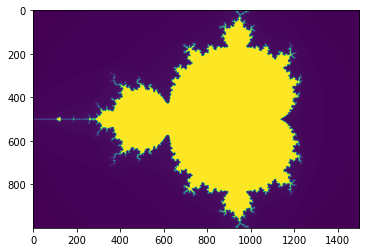

In [4]:
# creamos la imagen
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

# ejecutamos los calculos
normal = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

# mostramos todo
plt.imshow(image, cmap="viridis");

## Entra numba

31.3 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


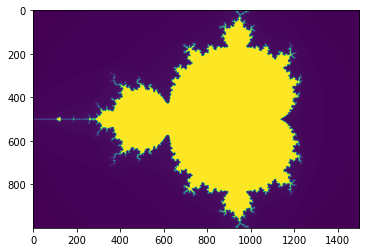

In [5]:
import numba

mandel = numba.jit(mandel)
create_fractal = numba.jit(create_fractal)

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)

jited = %timeit -o create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

plt.imshow(image, cmap="viridis");

## Mejora

87.49212122930811

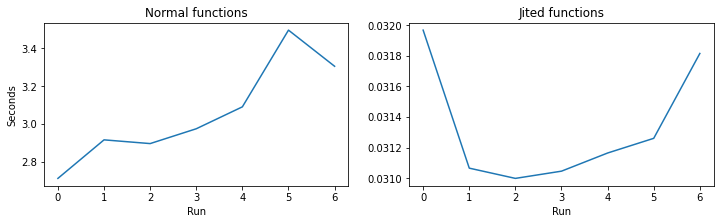

In [16]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 3)

axes[0].plot(normal.all_runs)
axes[0].set_title("Normal functions")
axes[0].set(xlabel="Run", ylabel="Seconds")

axes[1].plot(jited.all_runs)
axes[1].set_title("Jited functions")
axes[1].set(xlabel="Run", ylabel="")

normal.best / jited.best

## Qué es Numba?

- Numba traduce las funciones de de un **subset** de Python a código de máquina optimizado en tiempo de ejecución utilizando la **LLVM**. 
- Los algoritmos numéricos compilados con Numba en Python pueden acercarse a las velocidades de C o FORTRAN.
- Tambien brinda posibilidades de compilacion AOT y Eager compilation (compilación ansiosa)
- Está diseñado para usarse con matrices y funciones NumPy.  
- Los decoradores especiales pueden crear funciones universales que se transmiten a través de matrices NumPy al igual que las funciones NumPy.

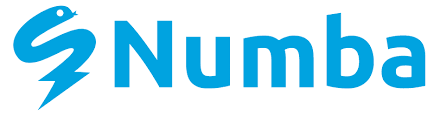

## LLVM Compiler Infrastructure Project

- Suministra las capas intermedias de un compilador completo, tomando el código en "forma intermedia" (IF) de un compilador y emitiendo un IF optimizado. 
- Este nuevo IF puede ser convertido a código de una máquina concreta.
- Puede generar código máquina relocalizable en el momento de compilación, de enlazado, o de ejecución.

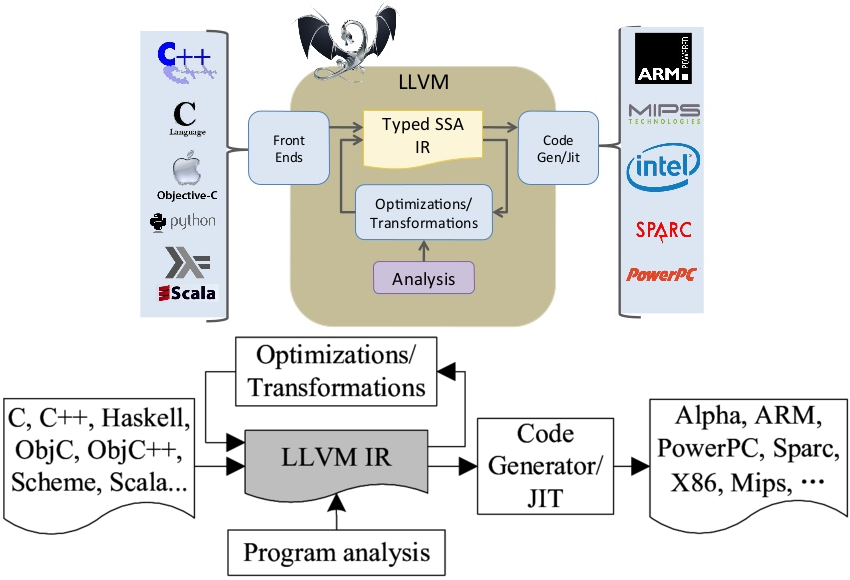

## Como funciona Numba

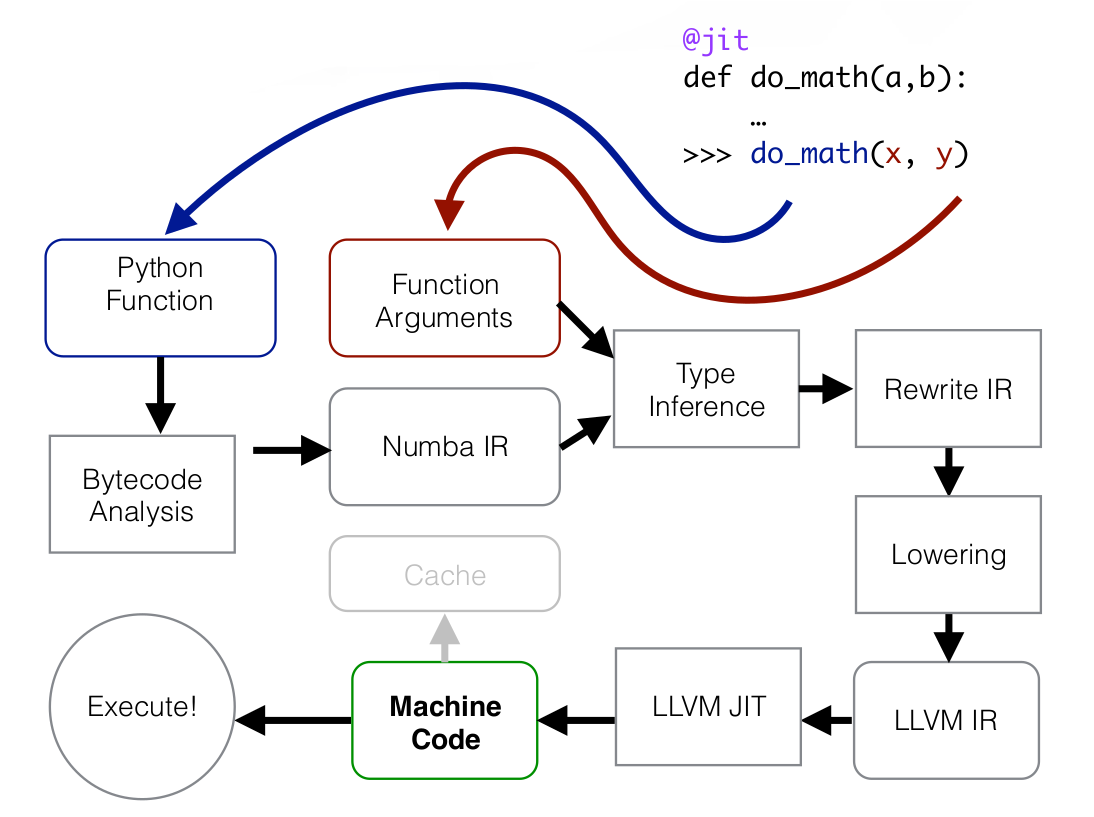

## Alternativas

- Julia es "mas-o-menos" esto. Es muchos aspectos es "menos" JIT y "más" AOT.
- PyPy es un JIT general que reemplaza el de CPython.

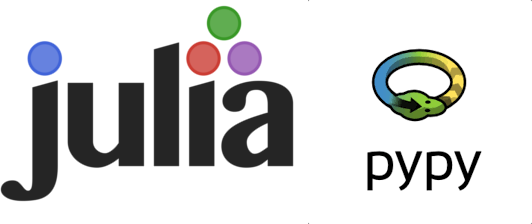

## Inferencia de tipos

In [17]:
@numba.jit
def add(a, b):
    return a + b

In [18]:
%%time
add(1, 1)

CPU times: user 28.8 ms, sys: 92 µs, total: 28.9 ms
Wall time: 28.1 ms


2

In [19]:
%%time
add(1, 1.)

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 26.8 ms


2.0

In [21]:
%%time
add("hola ", "mundo")

CPU times: user 37 µs, sys: 4 µs, total: 41 µs
Wall time: 43.4 µs


'hola mundo'

In [25]:
add.nopython_signatures

[(int64, int64) -> int64,
 (float64, int64) -> float64,
 (unicode_type, unicode_type) -> unicode_type,
 (int64, float64) -> float64]

## Numba object-mode

In [22]:
class ConEspacio:
    def __init__(self, v):
        self.v = v
    def __add__(self, other):
        return f"{self.v} {other.v}"

In [23]:
add(ConEspacio("hola"), ConEspacio("mundo"))

/tmp/ipykernel_25711/1236145457.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "add" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_25711/1236145457.py (3)

File "../../../../../../tmp/ipykernel_25711/1236145457.py", line 3:
<source missing, REPL/exec in use?>

  @numba.jit
/home/juanbc/proyectos/dis_ssw/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "add" was compiled in object mode without forceobj=True.

File "../../../../../../tmp/ipykernel_25711/1236145457.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/juanbc/proyectos/dis_ssw/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit 

'hola mundo'

## Inferencia de tipos

In [24]:
@numba.jit(nopython=True)  # numba.njit
def add(a, b):
    return a + b

add(1, 1)

2

In [25]:
add(ConEspacio("hola"), ConEspacio("mundo"))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_25711/548798359.py (3)[0m
[1m
File "../../../../../../tmp/ipykernel_25711/548798359.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.ConEspacio'>[0m
- argument 1: [1mCannot determine Numba type of <class '__main__.ConEspacio'>[0m


## Pero quiero usar object-mode sin warnings - Force Object mode

In [26]:
@numba.jit(forceobj=True)
def add(a, b):
    return a + b

In [27]:
add(1, 2)

3

In [28]:
add(ConEspacio("hola"), ConEspacio("Mundo"))

'hola Mundo'

## Pero quiero usar object-mode sin warnings - Objeto Facade

In [29]:
@numba.njit
def numba_add(a, b):
    return a + b

def add(a, b):
    try:
        return numba_add(a, b)
    except numba.TypingError:
        return a + b

In [30]:
add(ConEspacio("hola"), ConEspacio("Mundo"))

'hola Mundo'

## Pero quiero usar object-mode sin warnings -- Numba issue #4191

- https://github.com/numba/numba/issues/4191
- Comentario: https://github.com/numba/numba/issues/3907#issuecomment-500765025

```python
@numba.njit(fallback=sum)
def my_sum(a, b):
    return a + b
```

### Y versus numpy como andamos

In [33]:
def sincos(a, b):   
    return math.sin(a) * math.cos(b)

@numba.njit
def nb_sincos(a, b):   
    return math.sin(a) * math.cos(b)

def np_sincos(a, b):
    return np.sin(a) * np.cos(b)

normal_run = %timeit -o sincos(1.5, 2.45)
nb_run = %timeit -o nb_sincos(1.5, 2.45)
np_run = %timeit -o np_sincos(1.5, 2.45);

139 ns ± 5.73 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
154 ns ± 13.9 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
1.38 µs ± 40.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Universal functions

- Una función universal (o **ufunc** para abreviar) es una función que funciona en `ndarrays` de manera elemento por elemento, que admite el broadcasting de matrices y la conversión de tipos.

In [38]:
np.multiply(2, 2)

4

In [39]:
np.multiply([1, 2, 3, 4], 2)

array([2, 4, 6, 8])

In [40]:
np.multiply([1, 2., 3, 4], 2)

array([2., 4., 6., 8.])

In [41]:
mtx = [
    [1, 2, 3, 4], 
    [5, 6, 7, 8]
]
np.multiply(mtx, [0, 0, 1, 0])

array([[0, 0, 3, 0],
       [0, 0, 7, 0]])

## Universal functions

- Las funciones universales se definen en C
- Este es un ejemplo del tutorial de la funcion *logit* **SOLO** para `double`.

```C
static void double_logit(char **args, npy_intp *dimensions, npy_intp* steps, void* data){
    npy_intp i;
    npy_intp n = dimensions[0];
    char *in = args[0], *out = args[1];
    npy_intp in_step = steps[0], out_step = steps[1];
    double tmp;
    for (i = 0; i < n; i++) {
        tmp = *(double *)in;
        tmp /= 1-tmp;
        in += in_step;
        out += out_step;
    }
}
```


Osea... NO

## Funciones vectorizadas

- Funcionan igual pero el rendimiento es puro Python

$
logit(p) = \log{\frac{p}{1 - p}}
$

In [34]:
@np.vectorize
def logit(p):
    if 0 < p > 1:
        raise ValueError()
    elif p == 0:
        return -np.inf
    elif p == 1:
        return np.inf
    return math.log(p / (1. - p))

In [35]:
logit(.5)

array(0.)

In [36]:
logit([0, 0.25, 0.5, 0.75, 1])

array([       -inf, -1.09861229,  0.        ,  1.09861229,         inf])

In [37]:
logit([[1, 0], [.5, .75]])

array([[       inf,       -inf],
       [0.        , 1.09861229]])

In [38]:
arr = np.random.random(size=(1000, 1000))
n_logit = %timeit -o logit(arr)

249 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Funciones vectorizadas -- Con Numba

In [46]:
@numba.vectorize
def logit(p):
    if 0 < p > 1:
        raise ValueError()
    elif p == 0:
        return -np.inf
    elif p == 1:
        return np.inf
    return math.log(p / (1. - p))

In [47]:
nb_logit = %timeit -o logit(arr)

5.96 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
# (hace 3 años daba 15 veces mejor)
# (hace 2 años daba 35 veces mejor)
# (hace 1 años daba 45 veces mejor)
n_logit.best / nb_logit.best

42.61524877331478

## Funciones vectorizadas -- Con Numba Parallel + Eager compilation

In [49]:
@numba.vectorize([numba.float64(numba.float64), numba.int64(numba.float64)], target="parallel") # cpu, parallel, cuda
def logit(p):
    if 0 < p > 1:
        raise ValueError()
    elif p == 0:
        return -np.inf
    elif p == 1:
        return np.inf
    return math.log(p / (1. - p))

In [50]:
nb_logit = %timeit -o logit(arr)

3 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
n_logit.best / nb_logit.best  # años anteriores 81x - 116x - 86x

86.51119321387452

## AOT

- Esto es si quiero distribuir modulos compilados en numba o que se compilen al momento de ejecución.
- No funciona para universal functions (todavía).
- Imaginemos que tenemos un modulo llamado `mult_src.py` con el siguiente código.

In [57]:
import numba
from numba.pycc import CC

cc = CC('mult')

@cc.export('mult', 'f8(f8, f8)')
@cc.export('mult', 'i4(i4, i4)')
def mult(a, b):
    return a * b

## AOT

- Crear un `setup.py` al lado de `pyproject.toml`

```python
from setuptools import setup

from mult_src import cc

setup(ext_modules=[cc.distutils_extension()])
```

Y al pyproject

```toml
[build-system]
requires = ["setuptools", "numba"]
build-backend = "setuptools.build_meta"
```

- Luego ejecutar `pip install -q build && python -m build`
- Y ya pueden importar `import mult`

## Wisdom words

- Perfilar primero, perfilar despues.
- Detectar cuellos de botella.
- Poner los cuellos de botella en una funcion jit-eada separada.
- No tirar `@jit` por todos lados.
- Preferir siempre `@njit`.
- Si les anda lento: Numba, Cython, Fortran, C.
- Todo lo expuesto puede haber caducado al final de la clase. [Numba se mueve rápido.](https://github.com/numba/numba/graphs/contributors)

## Referencias

- https://en.wikipedia.org/wiki/Just-in-time_compilation
- https://www.slideshare.net/teoliphant/fast-and-scalable-python
- https://numba.pydata.org
- Lattner, C., & Adve, V. (2004, March). LLVM: A compilation framework for lifelong program analysis & transformation. In Proceedings of the international symposium on Code generation and optimization: feedback-directed and runtime optimization (p. 75). IEEE Computer Society. (http://web6.cs.columbia.edu/~junfeng/10fa-e6998/papers/llvm.pdf)
- https://es.wikipedia.org/wiki/LLVM
- https://www.youtube.com/watch?v=1AwG0T4gaO0&t=3711s
- https://docs.scipy.org/doc/numpy/user/c-info.ufunc-tutorial.html